### Videogame Sales Prediction Model

## Environment and System Checks

In [1]:
import sys
import platform
import os
from datetime import datetime

print("Run timestamp:", datetime.now().isoformat(timespec="seconds"))
print("Python version:", sys.version)
print("Platform:", platform.platform())
print("Working directory:", os.getcwd())
print("Files here:", os.listdir())

Run timestamp: 2025-12-31T11:15:53
Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Platform: Windows-10-10.0.26200-SP0
Working directory: C:\Users\Robert\Desktop\d804-advanced-ai-for-computer-scientists\D804_PA_Videogame_Sales_Prediction\notebooks
Files here: ['vgsales_prediction_model.ipynb']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)

NumPy: 2.4.0
Pandas: 2.3.3


## Load Raw Data

In [3]:
DATA_PATH = "../data/vgsales_raw.csv"

# Quick path check
print("Looking for:", os.path.abspath(DATA_PATH))
print("Exists?", os.path.exists(DATA_PATH))

df_raw = pd.read_csv(DATA_PATH)

print("Shape:", df_raw.shape)
df_raw.head()

Looking for: C:\Users\Robert\Desktop\d804-advanced-ai-for-computer-scientists\D804_PA_Videogame_Sales_Prediction\data\vgsales_raw.csv
Exists? True
Shape: (16598, 11)


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


## Data Audit and Quality Checks

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [5]:
missing = df_raw.isna().sum().sort_values(ascending=False)
missing[missing > 0]

Year         271
Publisher     58
dtype: int64

In [6]:
dup_count = df_raw.duplicated().sum()
print("Duplicate rows:", dup_count)

Duplicate rows: 0


## Descriptive Statistics

In [7]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Rank,16598.0,8300.605254,4791.853933,1.00,4151.25,8300.50,12449.75,16600.00
Year,16327.0,2006.406443,5.828981,1980.00,2003.00,2007.00,2010.00,2020.00
NA_Sales,16598.0,0.264667,0.816683,0.00,0.00,0.08,0.24,41.49
EU_Sales,16598.0,0.146652,0.505351,0.00,0.00,0.02,0.11,29.02
JP_Sales,16598.0,0.077782,0.309291,0.00,0.00,0.00,0.04,10.22
Other_Sales,16598.0,0.048063,0.188588,0.00,0.00,0.01,0.04,10.57
Global_Sales,16598.0,0.537441,1.555028,0.01,0.06,0.17,0.47,82.74


## Feature Selection for Gaussian Mixture Model

In [8]:
FEATURES = ["Year", "Global_Sales"]

df = df_raw[FEATURES].copy()

print("Selected feature shape:", df.shape)
df.head()

Selected feature shape: (16598, 2)


,Year,Global_Sales
0,2006.0,82.74
1,1985.0,40.24
2,2008.0,35.82
3,2009.0,33.00
4,1996.0,31.37


## Handle Missing Values

In [9]:
df_before = df.shape[0]

df = df.dropna()

df_after = df.shape[0]

print(f"Rows before: {df_before}")
print(f"Rows after : {df_after}")
print(f"Removed    : {df_before - df_after}")

Rows before: 16598
Rows after : 16327
Removed    : 271


## Feature Scaling

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

X_scaled[:5]

array([[-0.06973016, 52.50086969],
       [-3.67252844, 25.35618299],
       [ 0.27339349, 22.53313558],
       [ 0.44495531, 20.73200578],
       [-1.78534838, 19.69092721]])

## Fit a Gaussian Mixture Model (GMM)

In [11]:
from sklearn.mixture import GaussianMixture

# Initial GMM with a reasonable starting number of components
gmm = GaussianMixture(
    n_components=3,
    covariance_type="full",
    random_state=42
)

gmm.fit(X_scaled)

,"n_components n_components: int, default=1The number of mixture components.",3
,"covariance_type covariance_type: {'full', 'tied', 'diag', 'spherical'}, default='full'String describing the type of covariance parameters to use.Must be one of:- 'full': each component has its own general covariance matrix.- 'tied': all components share the same general covariance matrix.- 'diag': each component has its own diagonal covariance matrix.- 'spherical': each component has its own single variance.For an example of using `covariance_type`, refer to:ref:`sphx_glr_auto_examples_mixture_plot_gmm_selection.py`.",'full'
,"tol tol: float, default=1e-3The convergence threshold. EM iterations will stop when thelower bound average gain is below this threshold.",0.001
,"reg_covar reg_covar: float, default=1e-6Non-negative regularization added to the diagonal of covariance.Allows to assure that the covariance matrices are all positive.",1e-06
,"max_iter max_iter: int, default=100The number of EM iterations to perform.",100
,"n_init n_init: int, default=1The number of initializations to perform. The best results are kept.",1
,"init_params init_params: {'kmeans', 'k-means++', 'random', 'random_from_data'}, default='kmeans'The method used to initialize the weights, the means and theprecisions.String must be one of:- 'kmeans' : responsibilities are initialized using kmeans.- 'k-means++' : use the k-means++ method to initialize.- 'random' : responsibilities are initialized randomly.- 'random_from_data' : initial means are randomly selected data points... versionchanged:: v1.1 `init_params` now accepts 'random_from_data' and 'k-means++' as initialization methods.",'kmeans'
,"weights_init weights_init: array-like of shape (n_components, ), default=NoneThe user-provided initial weights.If it is None, weights are initialized using the `init_params` method.",None
,"means_init means_init: array-like of shape (n_components, n_features), default=NoneThe user-provided initial means,If it is None, means are initialized using the `init_params` method.",None
,"precisions_init precisions_init: array-like, default=NoneThe user-provided initial precisions (inverse of the covariancematrices).If it is None, precisions are initialized using the 'init_params'method.The shape depends on 'covariance_type':: (n_components,) if 'spherical', (n_features, n_features) if 'tied', (n_components, n_features) if 'diag', (n_components, n_features, n_features) if 'full'",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given to the method chosen to initialize theparameters (see `init_params`).In addition, it controls the generation of random samples from thefitted distribution (see the method `sample`).Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42


## Assign Cluster Labels and Probabilities

In [12]:
# Hard cluster labels
cluster_labels = gmm.predict(X_scaled)

# Soft probabilities (one column per cluster)
cluster_probs = gmm.predict_proba(X_scaled)

print("Cluster label counts:")
pd.Series(cluster_labels).value_counts().sort_index()

Cluster label counts:


0     5062
1    10409
2      856
Name: count, dtype: int64

## Add Cluster Labels to the Dataset

In [13]:
df_clustered = df.copy()
df_clustered["cluster"] = cluster_labels

df_clustered.head()

,Year,Global_Sales,cluster
0,2006.0,82.74,2
1,1985.0,40.24,2
2,2008.0,35.82,2
3,2009.0,33.00,2
4,1996.0,31.37,2


## Inspect Cluster Numeric Characteristics

In [14]:
df_clustered.groupby("cluster").agg(
    count=("Global_Sales", "count"),
    mean_year=("Year", "mean"),
    mean_sales=("Global_Sales", "mean"),
    median_sales=("Global_Sales", "median"),
    max_sales=("Global_Sales", "max")
)

,count,mean_year,mean_sales,median_sales,max_sales
cluster,,,,,
0,5062,2005.221849,0.734723,0.590,2.00
1,10409,2007.126237,0.104834,0.080,0.30
2,856,2004.658879,4.684544,3.175,82.74


## Visualize Clusters

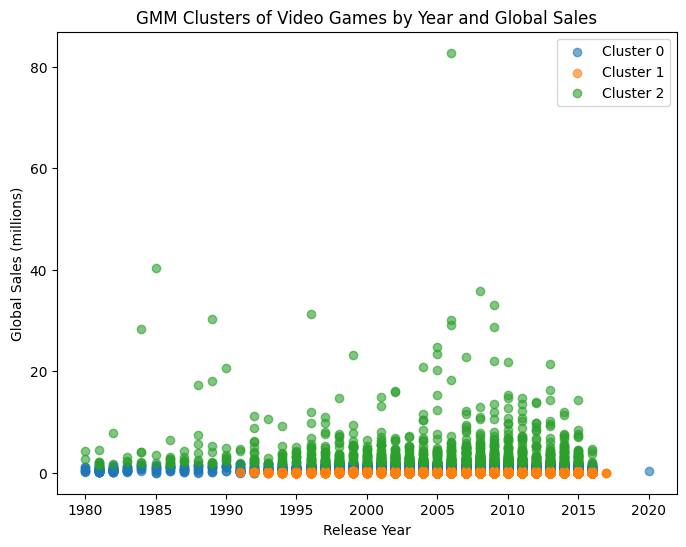

In [15]:
plt.figure(figsize=(8, 6))

for c in sorted(df_clustered["cluster"].unique()):
    subset = df_clustered[df_clustered["cluster"] == c]
    plt.scatter(
        subset["Year"],
        subset["Global_Sales"],
        label=f"Cluster {c}",
        alpha=0.6
    )

plt.xlabel("Release Year")
plt.ylabel("Global Sales (millions)")
plt.title("GMM Clusters of Video Games by Year and Global Sales")
plt.legend()
plt.show()

## Bringing Back Categorical Features for Interpretation

In [16]:
# Reattach genre using index alignment
df_interpret = df_clustered.copy()
df_interpret["Genre"] = df_raw.loc[df_interpret.index, "Genre"]

df_interpret.head()

,Year,Global_Sales,cluster,Genre
0,2006.0,82.74,2,Sports
1,1985.0,40.24,2,Platform
2,2008.0,35.82,2,Racing
3,2009.0,33.00,2,Sports
4,1996.0,31.37,2,Role-Playing


## Genre Distribution Within Each Probabilistic Cluster

In [17]:
genre_counts = (
    df_interpret
    .groupby(["cluster", "Genre"])
    .size()
    .reset_index(name="count")
)

genre_counts.head(10)

,cluster,Genre,count
0,0,Action,1086
1,0,Adventure,149
2,0,Fighting,310
3,0,Misc,472
4,0,Platform,337
5,0,Puzzle,125
6,0,Racing,400
7,0,Role-Playing,439
8,0,Shooter,478
9,0,Simulation,265


## Normalize Genre Distribution by Cluster

In [18]:
genre_percent = (
    genre_counts
    .assign(
        percent=lambda x: x.groupby("cluster")["count"]
                          .transform(lambda s: s / s.sum())
    )
    .sort_values(["cluster", "percent"], ascending=[True, False])
)

genre_percent.head(15)

,cluster,Genre,count,percent
0,0,Action,1086,0.214540
10,0,Sports,851,0.168115
8,0,Shooter,478,0.094429
3,0,Misc,472,0.093244
7,0,Role-Playing,439,0.086725
6,0,Racing,400,0.079020
4,0,Platform,337,0.066574
2,0,Fighting,310,0.061241
9,0,Simulation,265,0.052351
11,0,Strategy,150,0.029633


## Identify Dominant Genres by Cluster

In [19]:
top_genres = (
    genre_percent
    .groupby("cluster")
    .head(5)
)

top_genres

,cluster,Genre,count,percent
0,0,Action,1086,0.214540
10,0,Sports,851,0.168115
8,0,Shooter,478,0.094429
3,0,Misc,472,0.093244
7,0,Role-Playing,439,0.086725
12,1,Action,1990,0.191181
22,1,Sports,1335,0.128254
15,1,Misc,1164,0.111826
13,1,Adventure,1114,0.107023
19,1,Role-Playing,937,0.090018


## Visualization of Genre Composition by Cluster

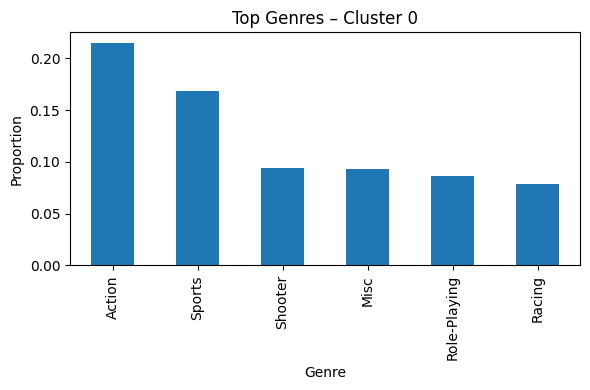

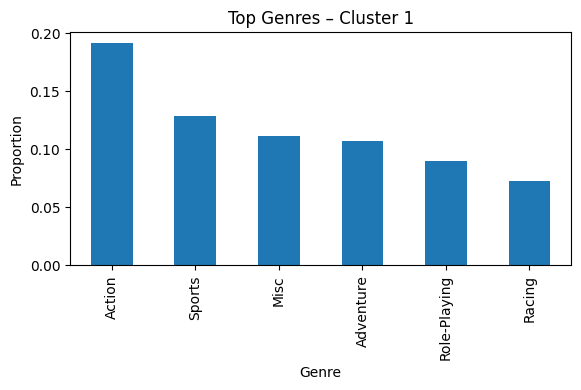

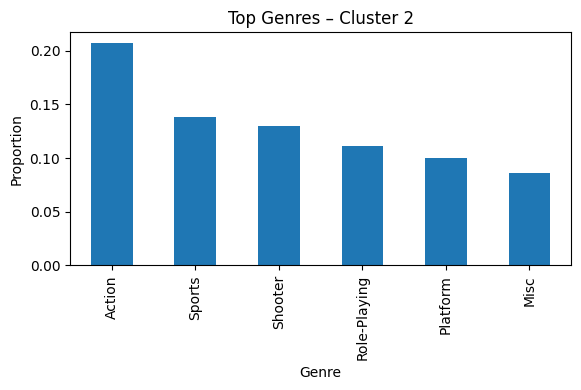

In [20]:
for c in sorted(df_interpret["cluster"].unique()):
    subset = genre_percent[genre_percent["cluster"] == c]
    subset.head(6).plot(
        x="Genre",
        y="percent",
        kind="bar",
        title=f"Top Genres – Cluster {c}",
        legend=False,
        figsize=(6, 4)
    )
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()

## Save the GMM Model File

### Large file

In [21]:
# Build a compact, viewable output table
output_df = df_interpret.copy()

# Reorder columns for readability
output_df = output_df[
    ["Year", "Global_Sales", "Genre", "cluster"]
]

# Save CSV
OUTPUT_PATH = "../data/vgsales_gmm_cluster_results.csv"
output_df.to_csv(OUTPUT_PATH, index=False)

print("Saved CSV:", OUTPUT_PATH)
print("Shape:", output_df.shape)
output_df.head()

Saved CSV: ../data/vgsales_gmm_cluster_results.csv
Shape: (16327, 4)


,Year,Global_Sales,Genre,cluster
0,2006.0,82.74,Sports,2
1,1985.0,40.24,Platform,2
2,2008.0,35.82,Racing,2
3,2009.0,33.00,Sports,2
4,1996.0,31.37,Role-Playing,2


### CSV File for Uploading to GitLab

In [22]:
import joblib

MODEL_PATH = "../data/vgsales_gmm_model.joblib"
joblib.dump(gmm, MODEL_PATH)

print("Saved model file:", MODEL_PATH)

Saved model file: ../data/vgsales_gmm_model.joblib
